## Clustering

In [2]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scaler
from sklearn import cluster, pipeline, preprocessing, compose
from sklearn.cluster import DBSCAN, KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import seaborn as sns

In [3]:
df = pd.read_csv('../cs4168-Project/EDA-tracks.csv')
print(df.shape)

(114000, 19)


In [4]:
df.head()

,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


For Clustering, we will need to drop some more columns due to them being text:
- `artists`
- `album_name`
- `track_name`
- `track_genre`

In [5]:
columns = ['artists', 'album_name', 'track_name', 'track_genre']
df = df.drop(columns=columns, axis=1)

df = df.drop(columns='duration_ms', axis=1)

In [6]:
df.head()

,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,73,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4
1,55,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4
2,57,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4
3,71,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3
4,82,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4


### Clustering

In [9]:
# Pipelines

k = 5
EPS = 1
MIN = 10

outliers = ['speechiness', 'explicit', 'liveness', 'instrumentalness']
outliers_zero = ['acousticness']
non_outliers = ['tempo', 'valence', 'popularity', 'key', 'danceability',
                'mode', 'energy', 'loudness', 'time_signature']

outliers_pipe = pipeline.Pipeline(
    steps= [
        ("log_transform", preprocessing.FunctionTransformer(np.log1p)), #log1p instead of log because it works for 0
        ("scaler", preprocessing.RobustScaler())
    ]
)
outliers_zero_pipe = pipeline.Pipeline(
    steps= [
        ("cubic_transform", preprocessing.FunctionTransformer(np.cbrt)),
        ("scaler", preprocessing.RobustScaler())
    ]
)

preprocessing_pipe = compose.ColumnTransformer(
    transformers = [
        ("outliers", outliers_pipe, outliers),
        ("outliers_zeros", outliers_zero_pipe, outliers_zero),
        ("non_outliers", preprocessing.FunctionTransformer(np.cbrt), non_outliers)
    ],
    remainder="passthrough"
)

kmeans_pipe = pipeline.Pipeline(
    steps= [
        ('preprocess', preprocessing_pipe),
        ('kmeans', KMeans(n_clusters=k, n_init=10, max_iter=300)),
    ]
)

dbscan_pipe = pipeline.Pipeline(
    steps=[
        ('scaler', preprocessing.StandardScaler()),
        ('dbscan', DBSCAN(eps=EPS, min_samples=MIN)),
    ]
)

### Elbow Method to find best K-Value

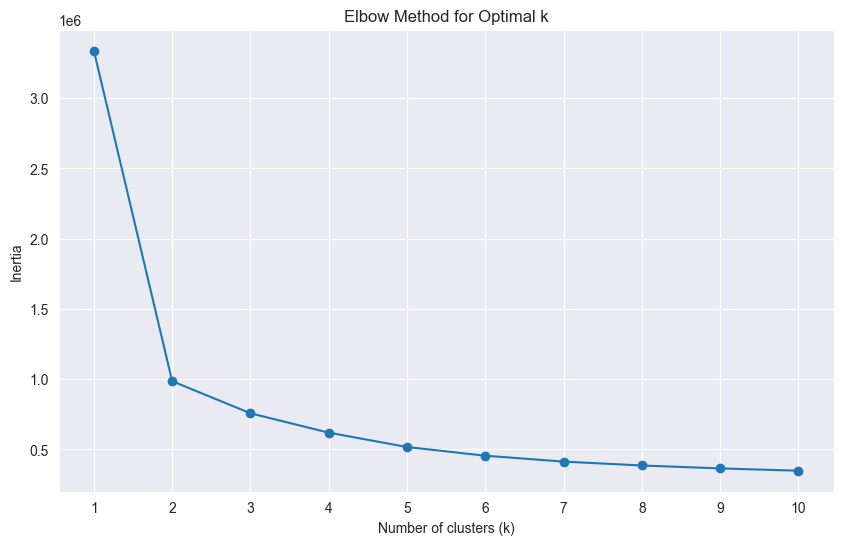

In [10]:
preprocessed_data = preprocessing_pipe.fit_transform(df)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(preprocessed_data)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


For k = 2, the silhouette score is 0.6947648824254824
For k = 3, the silhouette score is 0.5131074349642311
For k = 4, the silhouette score is 0.4166992044352848
For k = 5, the silhouette score is 0.40092230107578
For k = 6, the silhouette score is 0.4071323332287044
For k = 7, the silhouette score is 0.333304215367293
For k = 8, the silhouette score is 0.30776612917045565
For k = 9, the silhouette score is 0.30224744038048257
For k = 10, the silhouette score is 0.28493213839973397


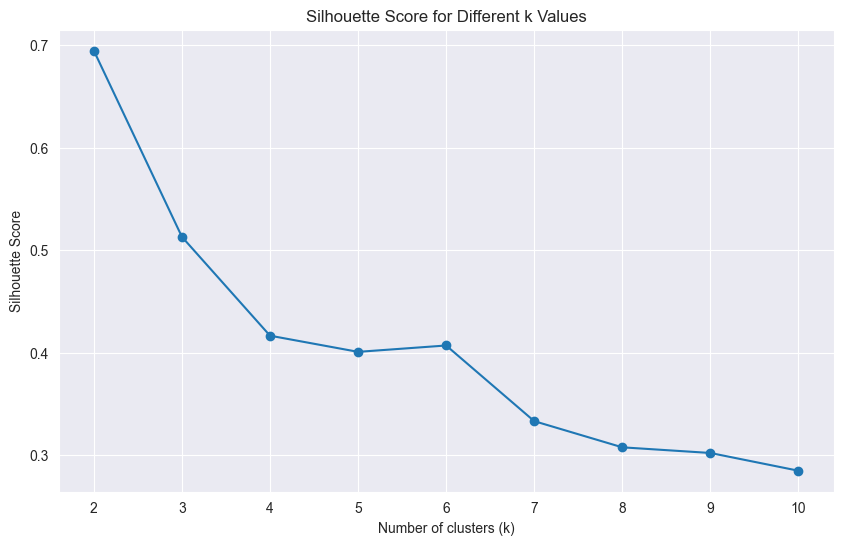

In [11]:
silhouette_scores = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(preprocessed_data)
    silhouette_avg = silhouette_score(preprocessed_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For k = {k}, the silhouette score is {silhouette_avg}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Different k Values')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()


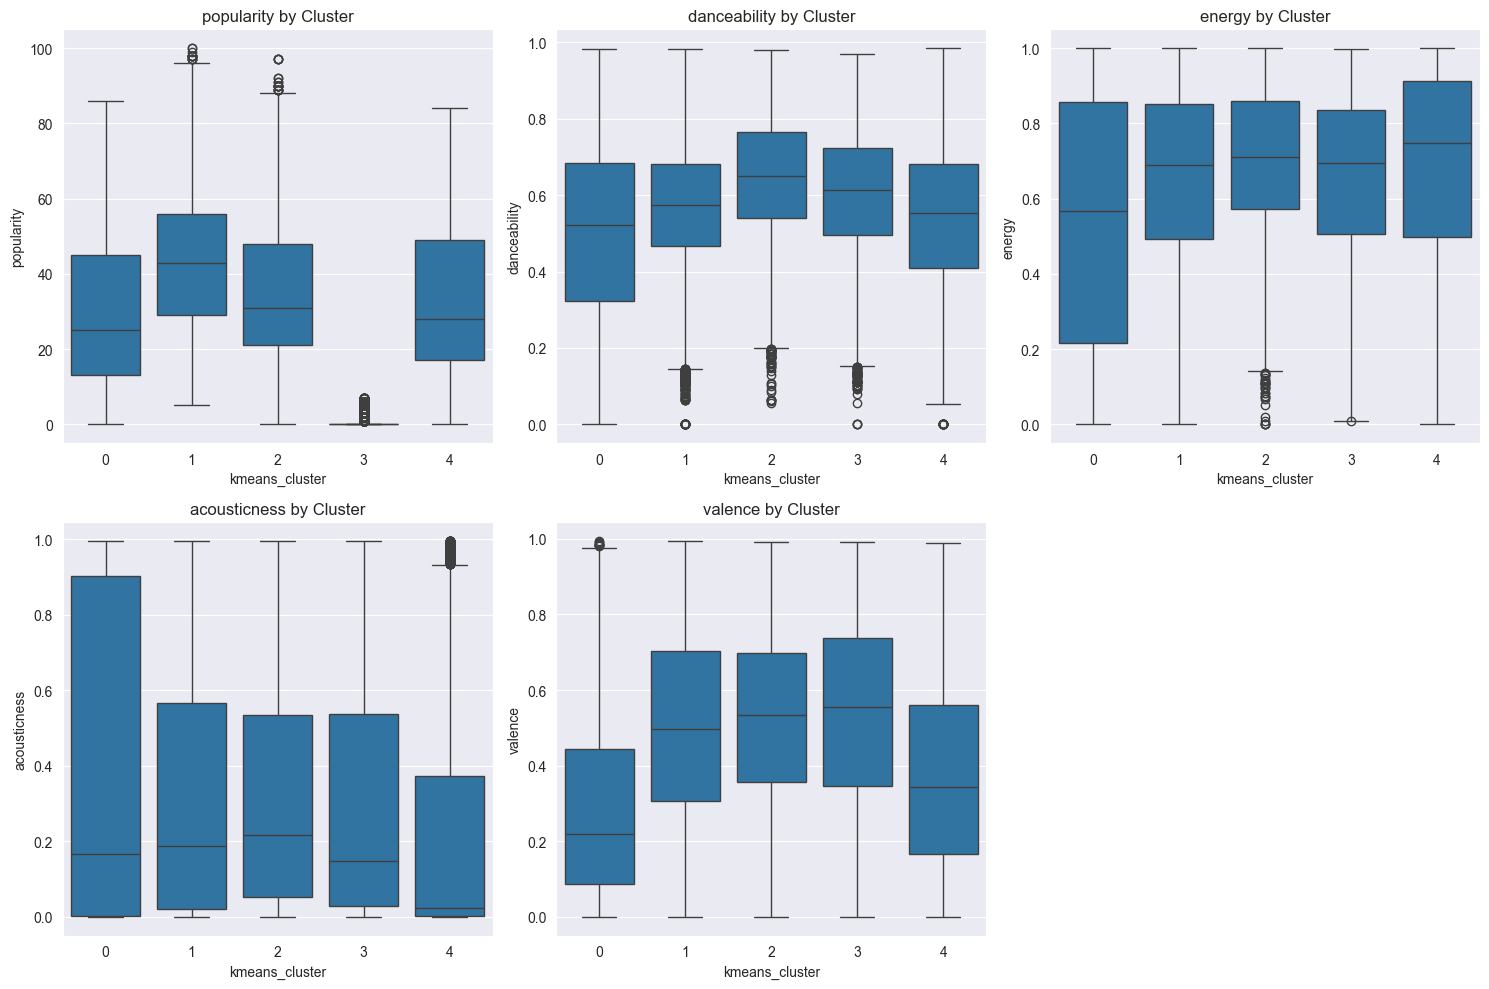

In [13]:
from sklearn.pipeline import Pipeline
optimal_k = 5  # This might change based on your analysis

# Apply KMeans with optimal k
kmeans_pipe = Pipeline([
    ('preprocess', preprocessing_pipe),
    ('kmeans', KMeans(n_clusters=optimal_k, n_init=10, random_state=42)),
])

# Fit and predict
cluster_labels = kmeans_pipe.fit_predict(df)
df['kmeans_cluster'] = cluster_labels

# Analyze clusters
plt.figure(figsize=(15, 10))
for i, feature in enumerate(['popularity', 'danceability', 'energy', 'acousticness', 'valence']):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='kmeans_cluster', y=feature, data=df)
    plt.title(f'{feature} by Cluster')
plt.tight_layout()
plt.show()

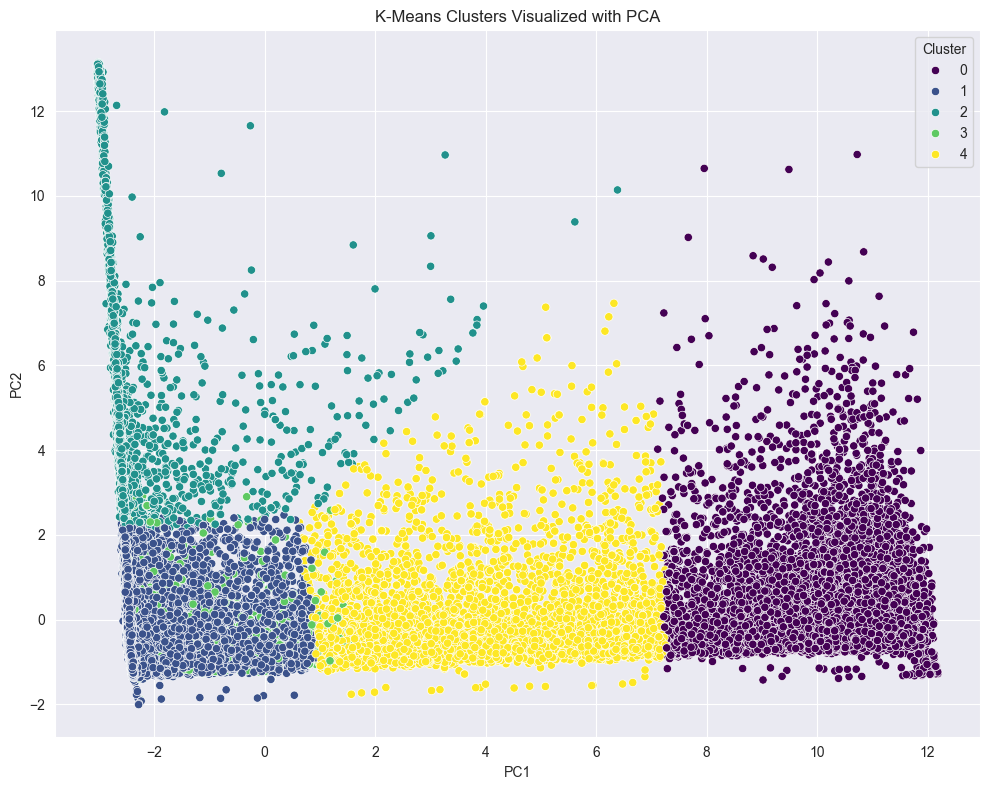

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(preprocessed_data)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

# Plot the clusters in 2D space
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis')
plt.title('K-Means Clusters Visualized with PCA')
plt.tight_layout()
plt.show()

## DBSCAN

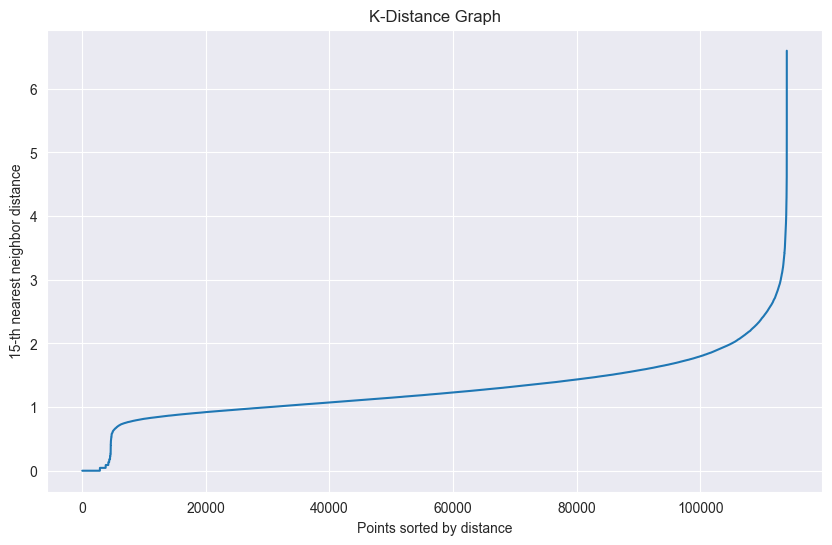

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop('kmeans_cluster', axis=1))


from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=15)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

# Sort and plot distances
distances = np.sort(distances[:, 14])
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('15-th nearest neighbor distance')
plt.grid(True)
plt.show()

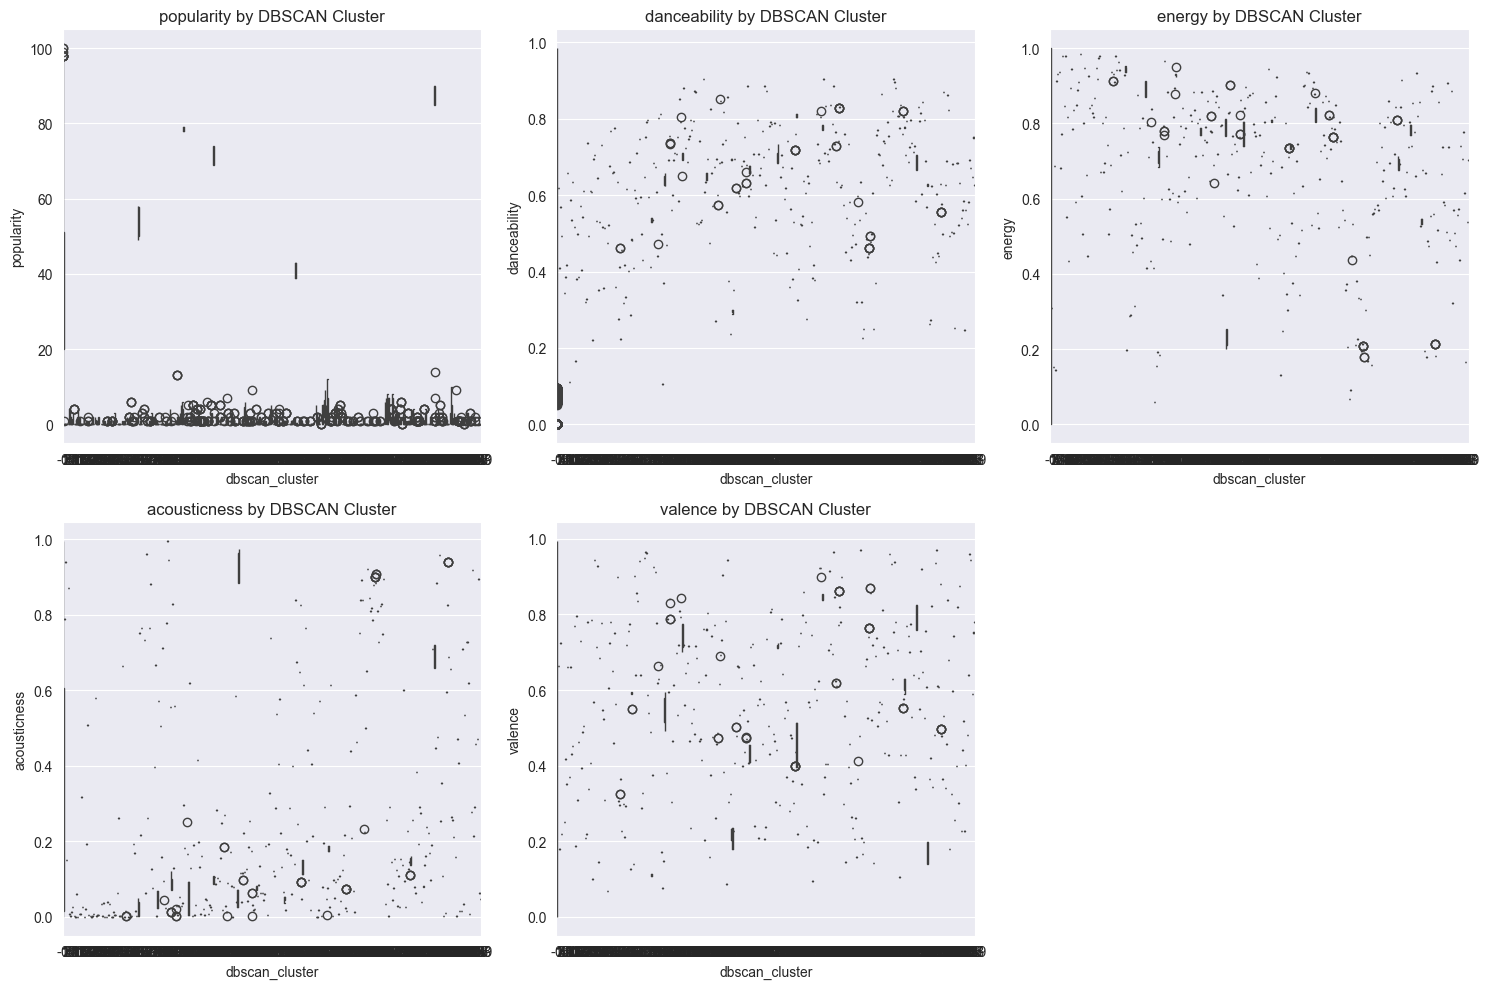

Number of points in each DBSCAN cluster (including noise points labeled as -1):
-1      107492
 70        146
 308        76
 110        73
 65         69
         ...  
 300        10
 336        10
 9          10
 6          10
 0          10
Name: count, Length: 341, dtype: int64


In [17]:
# Apply DBSCAN
dbscan_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('dbscan', DBSCAN(eps=0.5, min_samples=10)),  # Adjust eps based on k-distance graph
])


dbscan_labels = dbscan_pipe.fit_predict(df.drop('kmeans_cluster', axis=1))
df['dbscan_cluster'] = dbscan_labels

# Analyze clusters
plt.figure(figsize=(15, 10))
for i, feature in enumerate(['popularity', 'danceability', 'energy', 'acousticness', 'valence']):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='dbscan_cluster', y=feature, data=df)
    plt.title(f'{feature} by DBSCAN Cluster')
plt.tight_layout()
plt.show()

print("Number of points in each DBSCAN cluster (including noise points labeled as -1):")
print(pd.Series(dbscan_labels).value_counts())

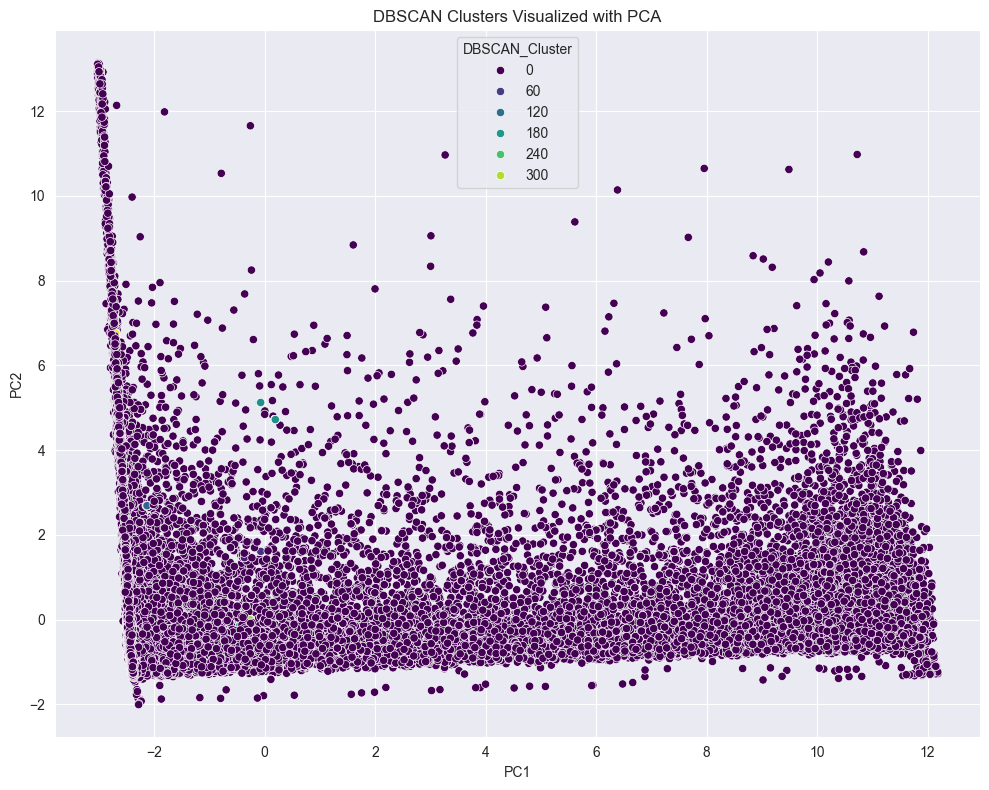

In [18]:
pca_df['DBSCAN_Cluster'] = dbscan_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='DBSCAN_Cluster', data=pca_df, palette='viridis')
plt.title('DBSCAN Clusters Visualized with PCA')
plt.tight_layout()
plt.show()